# Importing Dependices

In [1]:
import torch
device="cuda" if torch.cuda.is_available() else "cpu"
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Getting the Dataset

In [3]:
train_data=datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
test_data=datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [5]:
image,label=test_data[1]

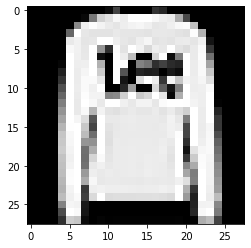

In [6]:
plt.imshow(image[0],cmap='gray')

In [7]:
image.shape

torch.Size([1, 28, 28])

In [8]:
label

2

In [9]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [10]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

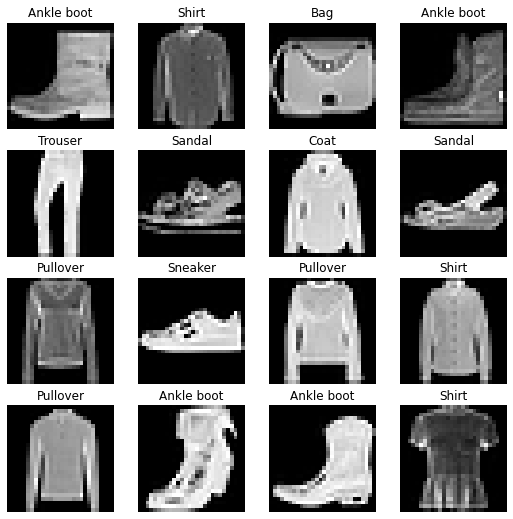

In [11]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# Preparing the DataLoader

In [12]:
from torch.utils.data import DataLoader

In [13]:
BATCH_SIZE=32

In [14]:
train_dataLoader=DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [15]:
test_dataLoader=DataLoader(
test_data,
batch_size=BATCH_SIZE,
shuffle=False)

In [16]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataLoader, test_dataLoader}") 
print(f"Length of train dataloader: {len(train_dataLoader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataLoader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fab897d9b20>, <torch.utils.data.dataloader.DataLoader object at 0x7fab892d0d30>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


# Building The Model

In [17]:
class ClassificationModel(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.Dense=nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape,hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units,output_shape),
        nn.ReLU()
    )
  def forward(self,x):
    return self.Dense(x)

In [18]:
torch.manual_seed(42)

# Need to setup model with input parameters
model = ClassificationModel(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model.to("cpu") # keep model on CPU to begin with 

ClassificationModel(
  (Dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [19]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [20]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

In [21]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Training the Model

In [67]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

In [68]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

In [69]:
epochs=3

In [70]:
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  # Training
  train_loss=0
  train_acc=0
  for batch,(X,y) in enumerate(train_dataLoader):
    model.train()
    # Forward Pass
    y_pred=model(X)
    # Calculate Loss
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    # Optimizer Zero Grad
    optimizer.zero_grad()
    # Backward Pass
    loss.backward()
    #Optimizer Step
    optimizer.step()
    # Print out how many samples have been seen
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataLoader.dataset)} samples")
    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
  train_loss /= len(train_dataLoader)
  train_acc/=len(train_dataLoader)
  ### Testing
  test_loss,test_acc=0,0
  model.eval()
  with torch.inference_mode():
    for X,y in test_dataLoader:
      # Forward Pass
      test_pred=model(X)
      # Calculate Loss
      test_loss+=loss_fn(test_pred, y)
      # Calculate Accuracy
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataLoader)
    test_acc /= len(test_dataLoader)
  print(f"\nTrain loss: {train_loss:.5f}, Train Accuracy: {train_acc} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------


NameError: ignored

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model, data_loader=test_dataLoader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

# **CNN Model**

In [22]:
class TinyVGG(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.block_1=nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=output_shape,
            kernel_size=3,
            stride=1,
            padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, 
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.Dense=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
    )
  def forward(self,x):
    x=self.block_1(x)
    x=self.block_2(x)
    x=self.Dense(x)
    return x

In [23]:
torch.manual_seed(42)
model_2 = TinyVGG(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)

In [24]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_2.parameters(),
                           lr=0.1)

In [25]:
torch.cuda.manual_seed(42)

In [26]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

In [27]:
epochs=3

In [28]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

In [29]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [30]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [31]:
for epoch in tqdm(range(epochs)):
   print(f"Epoch: {epoch}\n---------")
   train_step(model=model_2,
              data_loader=train_dataLoader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
   test_step(model=model_2,
             data_loader=test_dataLoader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.37137 | Train accuracy: 10.00%
Test loss: 2.31185 | Test accuracy: 9.99%

Epoch: 1
---------
Train loss: 2.31621 | Train accuracy: 9.90%
Test loss: 2.31545 | Test accuracy: 10.01%

Epoch: 2
---------
Train loss: 2.31633 | Train accuracy: 9.92%
Test loss: 2.31625 | Test accuracy: 10.00%

Train time on cuda: 52.313 seconds
